In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad

In [2]:
table = pd.read_csv('Heston_data_input')
X = table.drop(['C_price','delta'], axis=1)
y = table[['C_price']]
#X = df[['k','T','C_price']]
#y = df[['v0','rho','kappa','theta','sigma']]
T_loc = list(X.columns).index('T')
k_loc = list(X.columns).index('k') # log strike 

In [3]:
table['C_price'].describe()

count    63.000000
mean      0.285844
std       0.134396
min       0.005952
25%       0.251236
50%       0.289855
75%       0.381712
max       0.452502
Name: C_price, dtype: float64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.2, random_state=42)
input_scaler = preprocessing.MinMaxScaler()
output_scaler = preprocessing.MinMaxScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
#y_train_scaled = output_scaler.fit_transform(y_train)
#y_train_scaled = y_train # no scaling
#X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0],X_train_scaled.shape[1],1) # for lstm
X_test_scaled = input_scaler.transform(X_test)
#y_test_scaled = y_test # no scaling

#X_train_scaled = torch.FloatTensor(X_train_scaled,requires_grad=True)
#X_test_scaled = torch.FloatTensor(X_test_scaled,requires_grad=True)
X_train_scaled = torch.FloatTensor(X_train_scaled)
X_train_scaled.requires_grad = True
X_test_scaled = torch.FloatTensor(X_test_scaled)
X_test_scaled.requires_grad = True
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [5]:

num_neurons = 128


class Net(nn.Module):

    def __init__(self,num_input=7):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_input, num_neurons) 
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.fc3 = nn.Linear(num_neurons, num_neurons)
#        self.fc4 = nn.Linear(num_neurons, num_neurons)
#        self.fc5 = nn.Linear(num_neurons, num_neurons)
#        self.fc6 = nn.Linear(num_neurons, num_neurons)
        self.fc7 = nn.Linear(num_neurons, 1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
#        x = F.relu(self.fc3(x))
#        x = F.relu(self.fc4(x))
#        x = F.relu(self.fc5(x))
#        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        return x

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
#        torch.nn.init.normal_(m.weight)
#        xavier(m.weight.data)
#        xavier(m.bias.data)


In [6]:
model = Net()
model.apply(weights_init)
        
print(model)

Net(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=1, bias=True)
)


# Training

In [7]:
epochs = 30001
#epochs = 101
loss_arr = []
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
l2_lambda = 1e-5
criterion = nn.MSELoss()


for i in range(epochs):
    y_hat = model.forward(X_train_scaled)
    loss = criterion(y_hat, y_train)
    l2_reg = torch.tensor(0.)
    
    # Penalization (loop over each data)
    ## calendar arbitrage
    calendar_arbi_count = 0
    calendar_loss = torch.tensor(0.)
    butterfly_loss = torch.tensor(0.)
    for elem in X_train_scaled:
        y= model.forward(elem)
        dydx = grad(y, elem, create_graph = True)[0]
        dydT = dydx[T_loc]
        if dydT < 0.0:
            calendar_arbi_count += 1
            calendar_loss += torch.exp(-dydT) * 1e-1
    loss += calendar_loss
    ## butterfly arbitrage
    butterfly_count = 0
    dydk = dydx[k_loc] # dCdk w.r.t. log-strike 
    d2ydk2 = grad(dydx[k_loc],elem, create_graph = True)[0][k_loc] # d2Cdk2 w.r.t. log-strike
    # butterfly arbitrage: d2CdK2 = 1/K^2(d2Cdk2 - dCdk) > 0, d2Cdk2 > dCdk
    # dCdK = 1/K*dcdk
    # d2CdK2 = 1/e^2k * (d2Cdk2 - dCdk)
    butter_ineq = (d2ydk2 - dydk)/torch.exp(2.0*elem[k_loc])
    if butter_ineq < 0.0: # violation of butterfly arbitrage
        butterfly_count += 1
        butterfly_loss += torch.exp(-butter_ineq) * 1e-1    
    loss += butterfly_loss

    # regularizations
    for param in model.parameters():
        l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg
    loss_arr.append(loss)
    if calendar_arbi_count > 0: print('calendar ',i, ' ',calendar_arbi_count,' ',calendar_loss)
    if butterfly_count > 0: print('butterfly ',i, ' ',butterfly_count,' ',butterfly_loss)
 
    if i % 500 == 0:
        print(f'Epoch: {i} Loss: {loss}')
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 0.10169577598571777


C:\Users\golde\Anaconda3\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 500 Loss: 0.003935719840228558
Epoch: 1000 Loss: 0.002222724026069045
Epoch: 1500 Loss: 0.0019023290369659662
Epoch: 2000 Loss: 0.0017319407779723406
Epoch: 2500 Loss: 0.001621306873857975
Epoch: 3000 Loss: 0.001541770063340664
Epoch: 3500 Loss: 0.001477908925153315
Epoch: 4000 Loss: 0.0014213137328624725
Epoch: 4500 Loss: 0.0013679189141839743
Epoch: 5000 Loss: 0.0013155543711036444
Epoch: 5500 Loss: 0.001263322657905519
Epoch: 6000 Loss: 0.0012109517119824886
Epoch: 6500 Loss: 0.0011582517763599753
Epoch: 7000 Loss: 0.0011055199429392815
Epoch: 7500 Loss: 0.0010528801940381527
Epoch: 8000 Loss: 0.0010007033124566078
Epoch: 8500 Loss: 0.0009490797528997064
Epoch: 9000 Loss: 0.0008982847793959081
Epoch: 9500 Loss: 0.0008485986618325114
Epoch: 10000 Loss: 0.0008000796660780907
Epoch: 10500 Loss: 0.0007537497440353036
Epoch: 11000 Loss: 0.000707382510881871
Epoch: 11500 Loss: 0.0006634005112573504
Epoch: 12000 Loss: 0.0006214776658453047
Epoch: 12500 Loss: 0.0005819733487442136
ca

KeyboardInterrupt: 

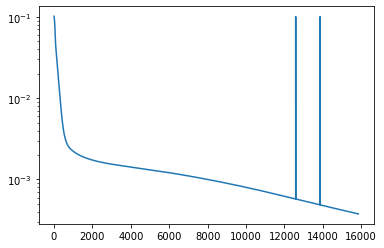

In [8]:
plt.plot(loss_arr)
plt.yscale('log')

# Finite Difference Scheme

In [13]:
inp1 = X_train_scaled[0].clone().detach()
dx = 1e-3
inp1[0] = torch.add(inp1[0],dx)

In [14]:
out1= model.forward(inp1)
dy = out1 - out
print(dy)

tensor([-0.0002], grad_fn=<SubBackward0>)


In [15]:
dydx = dy/dx

In [16]:
# 2nd order diff
x = []
ind = 0
tmp = X_train_scaled[0].clone().detach(); tmp.requires_grad = True
tmp[ind] -= dx
x.append(tmp)
tmp = X_train_scaled[0].clone().detach(); tmp.requires_grad = True
x.append(tmp)
tmp = X_train_scaled[0].clone().detach(); tmp.requires_grad = True
tmp[ind] += dx
x.append(tmp)
y = []
for elem in x:
    y.append(model.forward(elem))

dydx_fd = (y[2] - y[1]) / dx
d2ydx2_fd = (y[2] + y[0] - 2.*y[1]) / dx**2
print('1st diff FD ',dydx_fd)
print('2nd diff FD ',d2ydx2_fd)

1st diff FD  tensor([-0.1652], grad_fn=<DivBackward0>)
2nd diff FD  tensor([0.0596], grad_fn=<DivBackward0>)


# autograd

In [17]:
x = X_train_scaled[0].clone().detach()
x.requires_grad = True
y= model.forward(x)
dydx = grad(y,x, create_graph = True)[0]

In [18]:
if dydx[T_loc] < 0.0:
    print('nono ',torch.exp(dydx[T_loc] ))

In [19]:
d2ydx2 = grad(dydx[T_loc],x, create_graph = True)[0]

In [20]:
d2ydx2

tensor([ 8.7872e-05, -1.2255e-05, -3.9792e-05, -3.3263e-08,  1.1301e-04,
         1.4363e-06,  1.0488e-04], grad_fn=<SqueezeBackward1>)

In [21]:
x = X_train_scaled.clone().detach()
x.requires_grad = True
y= model.forward(x)

In [22]:
calendar_loss = torch.tensor(0.)
butterfly_loss = torch.tensor(0.)
for elem in X_train_scaled:
    y= model.forward(elem)
    dydx = grad(y, elem, create_graph = True)[0]
    dydT = dydx[T_loc]
    if dydT < 0.0:
        calendar_arbi_count += 1
        calendar_loss += torch.exp(-dydT[T_loc]) * 1e-1
    dydk = dydx[k_loc] # dCdk w.r.t. log-strike 
    d2ydk2 = grad(dydx[k_loc],elem, create_graph = True)[0][k_loc] # d2Cdk2 w.r.t. log-strike
    # dCdK = 1/K*dcdk
    # d2CdK2 = 1/e^2k * (d2Cdk2 - dCdk)
    # butterfly arbitrage: d2CdK2 = 1/K^2(d2Cdk2 - dCdk) > 0, d2Cdk2 > dCdk
    if d2ydk2 - dydk < 0.0: # violation of butterfly arbitrage
        butterfly_loss += torch.exp(-(d2ydk2 - dydk)) * 1e-1